# Idealized Case 3: Brownian Motion of Cells 

This tutorial shows the most important steps of tracking with `tobac` using an idealized case:

1. [Input Data](#1.-Input-Data)
2. [Feature Detection](#2.-Feature-Detection)
3. [Tracking / Trajectory Linking](#3.-Trajectory-Linking)
4. [Segmentation](#4.-Segmentation)
5. [Statistical Analysis](#5.-Statistical-Analysis)

In [135]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns

sns.set_context("talk")
np.random.seed(12345)

In [136]:
x_min, y_min, x_max, y_max, = 0, 0, 10, 10
t_min, t_max = 0, 100

x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
t = np.linspace(t_min, t_max, 50)

yy, xx = np.meshgrid(y, x, indexing='ij')

In [193]:
def create_brownian_features(x_0, y_0):
    
    x = x_0
    y = y_0
    
    pos_list = [(x, y)]
    
    for i in range(len(t)):
        ds = np.random.random()*0.5
        angle = np.random.random()*2*np.pi
        dx = ds*np.cos(angle)
        dy = ds*np.sin(angle)
        x+=dx
        y+=dy
        pos_list.append((x, y))
    
    return np.array(pos_list)

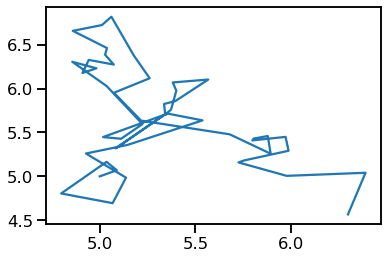

In [194]:
%matplotlib inline

features = create_brownian_features(5, 5)
plt.plot(features.T[0], features.T[1])

In [195]:
def create_array_from_features(features):
    
    x_0, y_0 = features[0]
    
    data = np.array([np.exp(-((xx-x)**2 + (yy-y)**2)/0.1) for x, y in features])
    return data>0.4

In [196]:
data = create_array_from_features(features)

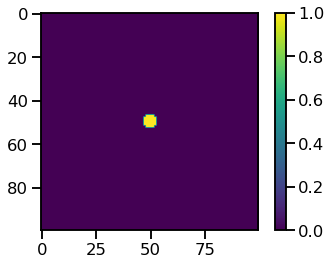

In [197]:
plt.imshow(data[0])
plt.colorbar()

In [198]:
def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y
             }
    
    attributes = {'units': ('m s-1')}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

In [199]:
data = create_xarray(data)

<IPython.core.display.Javascript object>


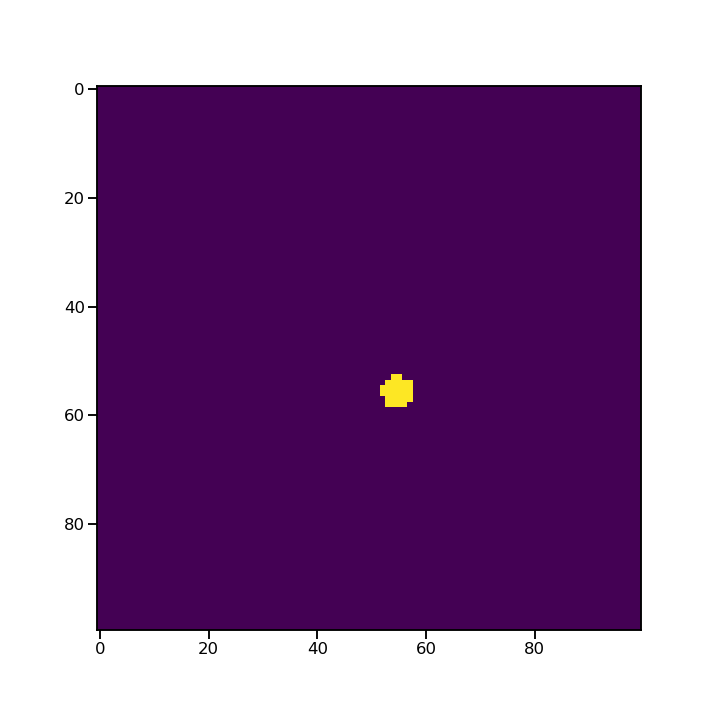

In [200]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10, 10))

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 50)

In [207]:
from scipy.ndimage import gaussian_filter

N = 0
while N < 51:
    
    if N == 0:
    
        features = create_brownian_features(np.random.random()*10, np.random.random()*10)
        data = create_array_from_features(features) > 0.7
        final_data = data
        N = 1
        
    else:
        
        features = create_brownian_features(np.random.random()*10, np.random.random()*10)
        data = create_array_from_features(features) > 0.5
        
        if np.all(np.logical_xor(data, final_data) + np.logical_not(data) + np.logical_not(final_data)):
        
            final_data = np.logical_or(final_data, data)
            N +=1
    
final_data = np.array(final_data, dtype='float64')    
data = gaussian_filter(create_xarray(final_data), 0.35)

<IPython.core.display.Javascript object>


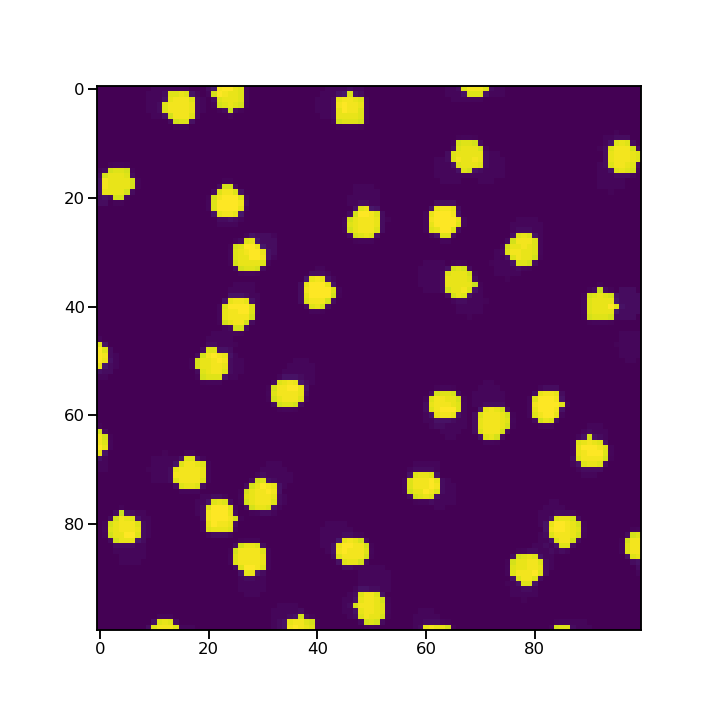

In [208]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10, 10))

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 50)
#anim.save('animation.mp4')

In [209]:
data = create_xarray(data)

Frame 50: 30 trajectories present.


Text(0.5, 1.0, 'predict')

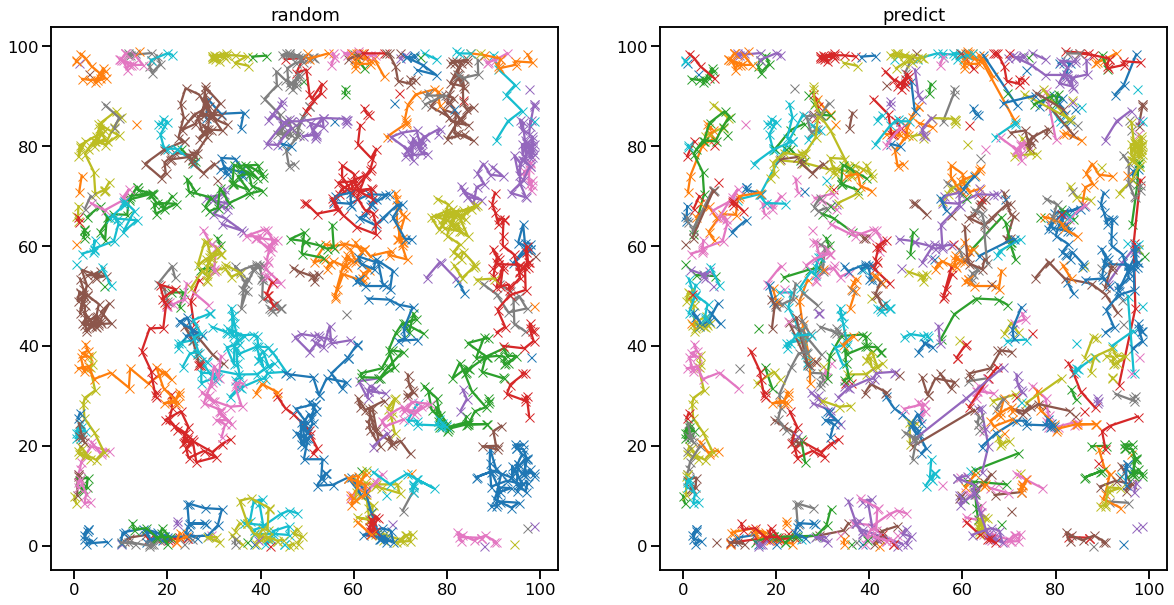

In [210]:
%matplotlib inline

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/50)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.1)
#mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.3)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1,
                                              method_linking='random',
                                              subnetwork_size=30)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1, 
                                              method_linking='predict',
                                              subnetwork_size=30)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

#ax1.imshow(blob[0], cmap = 'Greys', alpha = 0)
#ax2.imshow(blob[0], cmap = 'Greys', alpha = 0)

"""for i, track_i in track1.groupby('cell'):

    track_i.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax1,
        marker="x",
        label="cell {0}".format(int(i)),
    ) """
#ax1.legend()
for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='x',
            linestyle='-')
#ax2.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='x',
            linestyle='-')
#ax2.legend()
ax2.set_title('predict')

In [212]:
track1

<xarray.Dataset>
Dimensions:                  (index: 1722)
Coordinates:
  * index                    (index) int64 0 25 26 27 28 ... 1692 1720 1705 1721
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 50 50 50 50 50 50
    idx                      (index) int64 1 26 27 28 29 30 ... 3 2 1 29 14 30
    hdim_1                   (index) float64 3.289 61.62 70.0 ... 43.83 96.26
    hdim_2                   (index) float64 2.867 70.27 21.0 ... 29.5 55.19
    num                      (index) int64 45 48 45 46 45 48 ... 14 14 48 46 43
    threshold_value          (index) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    ...                       ...
    time                     (index) object 2022-04-01 00:00:00 ... 2022-04-0...
    timestr                  (index) object '2022-04-01 00:00:00' ... '2022-0...
    projection_x_coordinate  (index) float64 0.3322 6.225 7.071 ... 4.427 9.723
    projection_y_coordinate  (index) float64 0.2896 7.098 2.121 ... 2.98 5.574
    cell                     (index) float64 1.0 2.0 3.0 ... 204.0 40.0 197.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:01:00